# Synthetic example

1. Example data + subgroup atom values equations/example 
2. Larger synthetic example w/ visualization — exact
3. Larger synthetic example w/ visualization — imperfect

In [1]:
%load_ext watermark
%watermark

2020-06-13T14:54:03-04:00

CPython 3.7.6
IPython 7.15.0

compiler   : Clang 9.0.1 
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
import nhgisxwalk
import geopandas
import inspect
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas
import shapely
from shapely.geometry import Point, LineString, Polygon
import string

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
nhgisxwalk 0.0.2
numpy      1.18.5
geopandas  0.7.0
shapely    1.7.0
pandas     1.0.4
matplotlib 3.2.1



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

---------------------

## 1. Toy example

In [4]:
toy_df = nhgisxwalk.example_crosswalk_data()
toy_df

,bgp1990,blk1990,blk2010,trt2010,wt,pop_1990,hh_1990
0,A,A.1,X.1,X,1.0,60.0,25.0
1,A,A.2,X.2,X,0.3,100.0,40.0
2,A,A.2,Y.1,Y,0.7,100.0,40.0
3,B,B.1,X.3,X,1.0,50.0,20.0
4,B,B.2,Y.2,Y,1.0,80.0,30.0


### Function for calculating `atoms`:
 1. calculating weighted variable values
 2. grouping by 2 columns
 3. summing weighted variable values over #2

In [5]:
print(inspect.getsource(nhgisxwalk.calculate_atoms))

def calculate_atoms(
    df,
    weight=None,
    input_var=None,
    weight_var=None,
    weight_prefix=None,
    source_id=None,
    groupby_cols=None,
    overwrite_attrs=None,
):
    """Calculate the atoms (intersecting parts) of census geographies
    and interpolate a proportional weight of the source attribute that
    lies within the target geography.
    
    Parameters
    ----------
    
    df : pandas.DataFrame
        The input data. See ``GeoCrossWalk.base``.
    
    weight : str
        The weight colum name(s).
    
    input_var : str or iterable
        The input variable column name(s).
    
    weight_var : str or iterable
        The groupby and summed variable column name(s).
    
    weight_prefix : str
        Prepend this prefix to the the ``weight_var`` column name.
    
    source_id : str
        The source ID column name.
    
    groupby_cols : list
        The dataframe columns on which to perform groupby.
    
    overwrite_attrs : None or GeoCrossWalk

In [6]:
atom_df = nhgisxwalk.calculate_atoms(
    toy_df,
    weight="wt",
    input_var=["pop_1990", "hh_1990"],
    weight_var=["pop", "hh"],
    weight_prefix="wt_",
    source_id="bgp1990",
    groupby_cols=["bgp1990", "trt2010"]
)
atom_df

,bgp1990,trt2010,wt_pop,wt_hh
0,A,X,0.562500,0.569231
1,A,Y,0.437500,0.430769
2,B,X,0.384615,0.400000
3,B,Y,0.615385,0.600000


### Atoms for subgroups

**These atoms of `y1y2` unit intersections can then be used to calculate subgroups of variables with the following equation:**
## $atom_{\widehat{var}^{gu}} = total_{\widehat{var}^{gu}} \times \frac{atom_{var^{gu}}}{total_{var^{gu}}}$
**where:**
 * $var =$ a variable representing a count (i.e. population)
 * $\widehat{var} =$ a subgroup of a variable representing a count (i.e. asian population)
 * $gu =$ a geographic unit (i.e. block group part)

**For example, since we are considering the population variable, we will define the following:**
## $rg_i = \widehat{var}$
**where**
 * $pop = $ total population variable
 * ${rg}_i =$ the population of a specific racial group

## $atom_{rg_i^{bgp}} = total_{rg_i^{bgp}} \times \frac{atom_{pop^{bgp}}}{total_{pop^{bgp}}}$

**As an example, consider the are 30 people in racial group $i$ within block group part $A$ $({total}_{rg_i^{bgp}})$:**
* ${atom}_{rg_i^{AX}} = 16.875 = 30 \times \frac{90}{160}$
* ${atom}_{rg_i^{AY}} = 13.125 = 30 \times \frac{70}{160}$


--------------------

## 2. Larger synthetic example with visualization — exact
 * All smaller units fit exactly within larger units
   * `year1_small` units (blocks)
   * `year2_small` units (blocks)
   * `year1_medium` units (block group parts)
   * `year2_large` units (tracts)

### Create synthetic census geographies

In [7]:
def regular_lattice(bounds, length, width):
    """Create a regular lattice of polygons"""
    def _intervals(_min, _max, dim):
        return list(range(int(numpy.floor(_min)), int(numpy.ceil(_max)), dim))
    
    xmin, ymin, xmax, ymax = bounds
    rows = _intervals(ymin, ymax, length)
    cols = _intervals(xmin, xmax, width)
    polygons = [polygonize(i, j, length, width) for i in rows for j in cols]
    lattice = geopandas.GeoDataFrame({"geometry": polygons})
    return lattice

def irregular_lattice(poly_cords):
    """Create an irregular lattice of polygons"""
    polygons = [polygonize(*pc, regular=False) for pc in poly_cords]
    lattice = geopandas.GeoDataFrame({"geometry": polygons})
    return lattice

def polygonize(x, y, l, w, regular=True):
    """Create individual polygons"""
    if regular:
        ps = [(x,y), (x+w, y), (x+w, y+l), (x, y+l)]
    else:
        ps = [x, y, l, w]
    return Polygon(ps)

In [8]:
area = 12, 12
lparams = (0, 0, *area)
# ~ 1990 blocks
year1_small = regular_lattice(lparams, 3, 3)
# ~ 2010 blocks
year2_small = regular_lattice(lparams, 2, 2)
# ~ 1990 block group parts
year1_medium = regular_lattice(lparams, 6, 6)
# ~ 2010 tracts
year2_large = irregular_lattice(
    [((0,0), (6,0), (6,12), (0,12)), ((6,0), (12,0), (12,12), (6,12))]
)

### Visualize

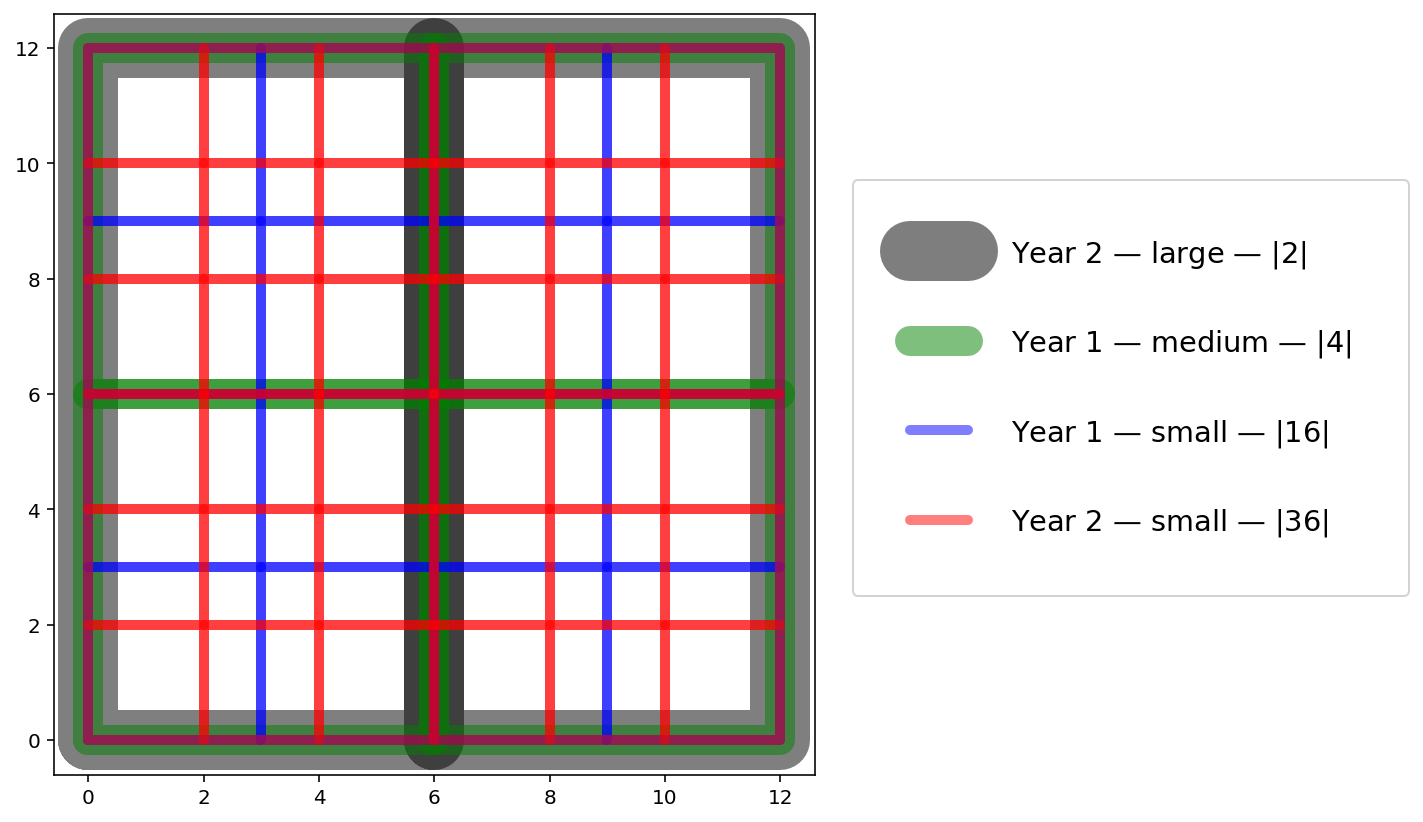

In [9]:
def plotter():
    def _patch(_kws, labinfo):
        _kws.update({"alpha":.5})
        label = "%s — %s — $|%s|$" % tuple(labinfo)
        _kws.update({"label":label, "solid_capstyle":"round"})
        p = matplotlib.lines.Line2D([], [], **_kws)
        return p
    
    def _legend(handles, anchor=(1.8, .8)):
        lkws = {"fancybox":True,"framealpha":0.85, "fontsize":"x-large"}
        lkws.update({"bbox_to_anchor": anchor, "labelspacing": 2.})
        lkws.update({"borderpad": 2., "handletextpad":1.5})
        matplotlib.pyplot.legend(handles=handles, **lkws)
    
    pltkws = {"alpha":.5, "capstyle":"round", "fc":"None"}
    base = year2_large.plot(figsize=(7,7), ec="k", lw=30, zorder=0, **pltkws)
    patches = [_patch({"lw":30, "c":"k"}, ["Year 2", "large", year2_large.shape[0]])]
    gdfs = [year1_medium, year1_small, year2_small]
    colors, lws, zo = ["g", "b", "r"], [15, 5, 5], [1 ,2 ,3]
    labels = [["Year 1", "medium"], ["Year 1", "small"], ["Year 2", "small"]]
    iterinfo = list(zip(gdfs, colors, lws, zo, labels))
    for gdf, c, l, z, lab in iterinfo:
        gdf.plot(ax=base, ec=c, lw=l, zorder=z, **pltkws)
        patches.append(_patch({"lw":l,"c":c}, lab+[gdf.shape[0]]))
    _legend(patches)

plotter()

### Record Hierarchical Membership

In [10]:
def hiearchy_ids(l_df, s_df, prefix, idcol="ID"):
    """(Dis)Aggregated pseudo-GEOIDs"""
    # larger spatial units
    l_df[idcol] = ["%s0%s0" % (prefix, i) for i in range(l_df.shape[0])]
    l_df = l_df[[idcol, "geometry"]]
    # smaller spatial units
    s_df = geopandas.overlay(s_df, l_df)
    for _id, _df in s_df.groupby(idcol):
        xi = range(_df.shape[0])
        s_df.loc[_df.index, idcol] = [_id+".s"+str(x).ljust(3,"0") for x in xi]
    return l_df, s_df

### Year 1 IDs — "block groups and blocks"

In [11]:
year1_medium, year1_small = hiearchy_ids(year1_medium, year1_small, "y1_M")
year1_medium

,ID,geometry
0,y1_M000,"POLYGON ((0.00000 0.00000, 6.00000 0.00000, 6...."
1,y1_M010,"POLYGON ((0.00000 6.00000, 6.00000 6.00000, 6...."
2,y1_M020,"POLYGON ((6.00000 0.00000, 12.00000 0.00000, 1..."
3,y1_M030,"POLYGON ((6.00000 6.00000, 12.00000 6.00000, 1..."


In [12]:
year1_small.head(10)

,ID,geometry
0,y1_M000.s000,"POLYGON ((0.00000 0.00000, 0.00000 3.00000, 3...."
1,y1_M000.s100,"POLYGON ((0.00000 3.00000, 0.00000 6.00000, 3...."
2,y1_M000.s200,"POLYGON ((3.00000 0.00000, 3.00000 3.00000, 6...."
3,y1_M000.s300,"POLYGON ((3.00000 3.00000, 3.00000 6.00000, 6...."
4,y1_M010.s000,"POLYGON ((0.00000 6.00000, 0.00000 9.00000, 3...."
5,y1_M010.s100,"POLYGON ((0.00000 9.00000, 0.00000 12.00000, 3..."
6,y1_M010.s200,"POLYGON ((3.00000 6.00000, 3.00000 9.00000, 6...."
7,y1_M010.s300,"POLYGON ((3.00000 9.00000, 3.00000 12.00000, 6..."
8,y1_M020.s000,"POLYGON ((6.00000 0.00000, 6.00000 3.00000, 9...."
9,y1_M020.s100,"POLYGON ((6.00000 3.00000, 6.00000 6.00000, 9...."


### Year 2 IDs — "tracts and blocks"

In [13]:
year2_large, year2_small = hiearchy_ids(year2_large, year2_small, "y2_L")
year2_large

,ID,geometry
0,y2_L000,"POLYGON ((0.00000 0.00000, 6.00000 0.00000, 6...."
1,y2_L010,"POLYGON ((6.00000 0.00000, 12.00000 0.00000, 1..."


In [14]:
year2_small[12:21]

,ID,geometry
12,y2_L000.s120,"POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6...."
13,y2_L000.s130,"POLYGON ((4.00000 2.00000, 4.00000 4.00000, 6...."
14,y2_L000.s140,"POLYGON ((4.00000 4.00000, 4.00000 6.00000, 6...."
15,y2_L000.s150,"POLYGON ((4.00000 6.00000, 4.00000 8.00000, 6...."
16,y2_L000.s160,"POLYGON ((4.00000 8.00000, 4.00000 10.00000, 6..."
17,y2_L000.s170,"POLYGON ((4.00000 10.00000, 4.00000 12.00000, ..."
18,y2_L010.s000,"POLYGON ((6.00000 0.00000, 6.00000 2.00000, 8...."
19,y2_L010.s100,"POLYGON ((6.00000 2.00000, 6.00000 4.00000, 8...."
20,y2_L010.s200,"POLYGON ((6.00000 4.00000, 6.00000 6.00000, 8...."


### Set synthetic population for `year1_small` parts

In [15]:
year1_small["pop_y1"] = range(1,year1_small.shape[0]+1)
year1_small["pop_y1"].sum()

136

### Create crosswalk (mimic of [the NHGIS crosswalk]())

In [16]:
def mimic_xwalk(df1, df1id, df2, df2id, wt="wt", _id="ID", geom="geometry"):
    """Mimic NHGIS crosswalk"""
    def wcalc(xa, xid):
        """Weight calculation helper"""
        return xa / df1.loc[(df1[_id]==xid), geom].squeeze().area
    
    xw = geopandas.overlay(df1, df2)
    xw = xw[[df1id, df2id, geom]]
    xw[wt] = xw.apply(lambda rec: wcalc(rec[geom].area, rec[df1id]), axis=1)
    xw = extract_higher_ids(xw, [df1id, df2id])
    return xw

def extract_higher_ids(df, cols):
    """Extract the higher order IDs"""
    for c in cols:
        df["_%s"%c.lower()] = df[c].apply(lambda x: x.split(".")[0])
    return df

In [17]:
small_xwalk = mimic_xwalk(year1_small, "ID_1", year2_small, "ID_2")
small_xwalk.head()

,ID_1,ID_2,geometry,wt,_id_1,_id_2
0,y1_M000.s000,y2_L000.s000,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2....",0.444444,y1_M000,y2_L000
1,y1_M000.s000,y2_L000.s100,"POLYGON ((0.00000 2.00000, 0.00000 3.00000, 2....",0.222222,y1_M000,y2_L000
2,y1_M000.s100,y2_L000.s100,"POLYGON ((0.00000 3.00000, 0.00000 4.00000, 2....",0.222222,y1_M000,y2_L000
3,y1_M000.s000,y2_L000.s600,"POLYGON ((3.00000 2.00000, 3.00000 0.00000, 2....",0.222222,y1_M000,y2_L000
4,y1_M000.s200,y2_L000.s600,"POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4....",0.222222,y1_M000,y2_L000


### Intersecting parts of `year1` and `year2` small units plotted by areal weight of `year1`

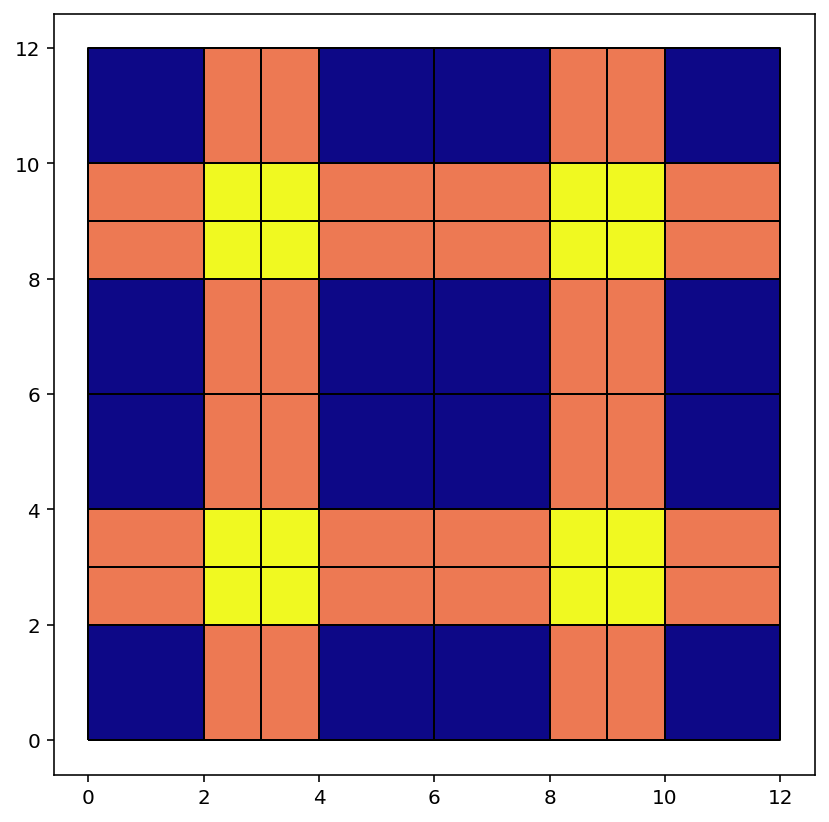

In [18]:
small_xwalk.plot(figsize=(7,7), cmap="plasma_r", column="wt", ec="k");

In [19]:
small_xwalk.drop("geometry", inplace=True, axis=1)

### Map the `year1_small` population to the crosswalk

In [20]:
pop_mapper = dict(year1_small[["ID", "pop_y1"]].values)
small_xwalk["pop_y1"] = small_xwalk["ID_1"].map(pop_mapper)
small_xwalk.head(10)

,ID_1,ID_2,wt,_id_1,_id_2,pop_y1
0,y1_M000.s000,y2_L000.s000,0.444444,y1_M000,y2_L000,1
1,y1_M000.s000,y2_L000.s100,0.222222,y1_M000,y2_L000,1
2,y1_M000.s100,y2_L000.s100,0.222222,y1_M000,y2_L000,2
3,y1_M000.s000,y2_L000.s600,0.222222,y1_M000,y2_L000,1
4,y1_M000.s200,y2_L000.s600,0.222222,y1_M000,y2_L000,3
5,y1_M000.s000,y2_L000.s700,0.111111,y1_M000,y2_L000,1
6,y1_M000.s100,y2_L000.s700,0.111111,y1_M000,y2_L000,2
7,y1_M000.s200,y2_L000.s700,0.111111,y1_M000,y2_L000,3
8,y1_M000.s300,y2_L000.s700,0.111111,y1_M000,y2_L000,4
9,y1_M000.s100,y2_L000.s200,0.444444,y1_M000,y2_L000,2


### Calculate the atoms

In [21]:
atom_df = nhgisxwalk.calculate_atoms(
    small_xwalk,
    weight="wt",
    input_var="pop_y1",
    weight_var="pop_y1y2",
    source_id="_id_1",
    groupby_cols=["_id_1", "_id_2"]
)
atom_df

,_id_1,_id_2,pop_y1y2
0,y1_M000,y2_L000,1.0
1,y1_M010,y2_L000,1.0
2,y1_M020,y2_L010,1.0
3,y1_M030,y2_L010,1.0


In [22]:
atom_df["pop_y1y2"].sum()

4.0

### Year 1 weighted population in Year 2
* year 1 "small" units crosswalk year 2 "small" units
* population of year 1 "medium" units built up from comprising year 1 "small" units
* year 2 "large" units built up from comprising year 2 "small" units
* result is year 1 weighted population estimates based in year 2 geographies

In [23]:
atom_df.groupby("_id_2")["pop_y1y2"].sum()

_id_2
y2_L000    2.0
y2_L010    2.0
Name: pop_y1y2, dtype: float64

In [24]:
M0s0 = year1_small[year1_small["ID"] == "y1_M000.s000"]
M0s1 = year1_small[year1_small["ID"] == "y1_M000.s100"]

### One unit of each geography over plotted `year_1` population

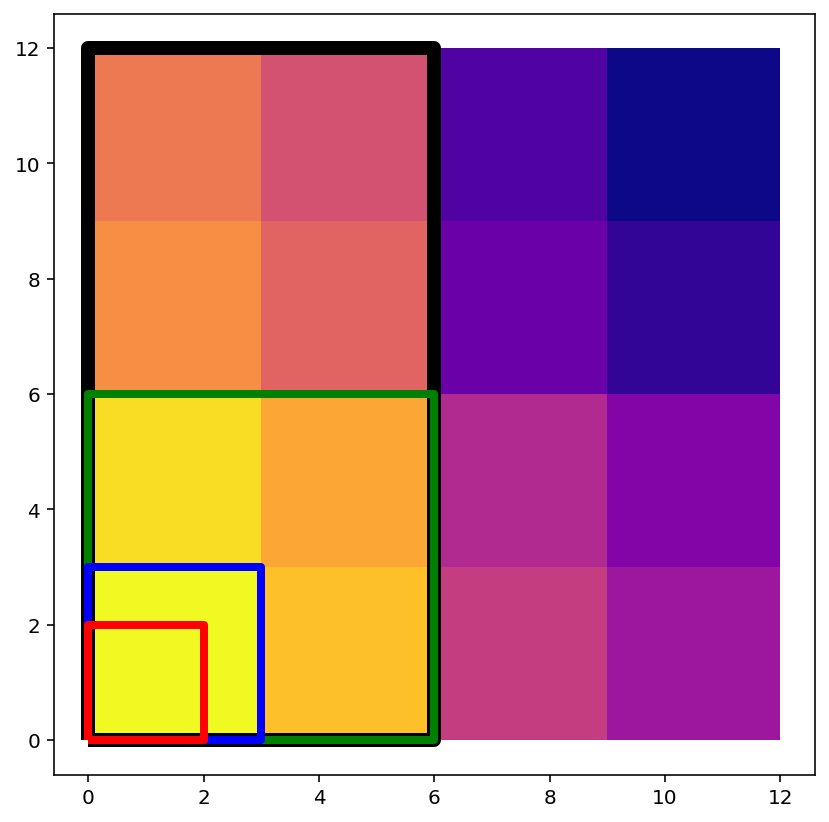

In [25]:
M000 = year1_medium[year1_medium["ID"] == "y1_M000"]
L000 = year2_large[year2_large["ID"] == "y2_L000"]
y1_M000s000 = year1_small[year1_small["ID"] == "y1_M000.s000"]
y2_L000s000 = year2_small[year2_small["ID"] == "y2_L000.s000"]
# plot
base = year1_small.plot(figsize=(7,7), cmap="plasma_r", column="pop_y1", zorder=0)
L000.plot(ax=base, ec="black", fc="None", lw=7, zorder=1)
M000.plot(ax=base, ec="green", fc="None", lw=4, zorder=2)
y1_M000s000.plot(ax=base, ec="blue", fc="None", lw=4, zorder=3)
y2_L000s000.plot(ax=base, ec="red", fc="None", lw=4, zorder=4);


--------------------

## 3. Larger synthetic example with visualization — imperfect

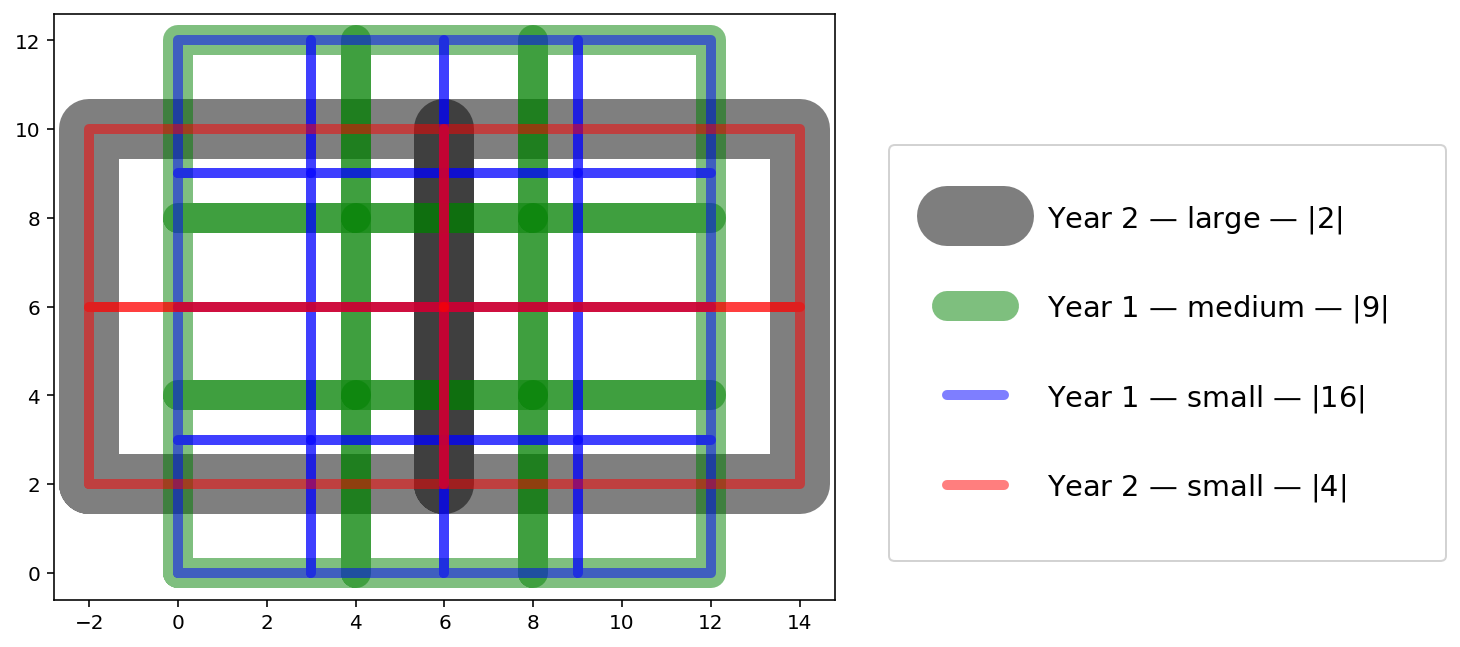

In [26]:
area = 12, 12
lparams = (0, 0, *area)
# ~ 1990 blocks
year1_small = regular_lattice(lparams, 3, 3)
# ~ 2010 blocks
year2_small = irregular_lattice(
    [
        ((-2,2), (6,2), (6,6), (-2,6)),
        ((6,2), (14,2), (14,6), (6,6)),
        ((-2,6), (6,6), (6,10), (-2,10)),
        ((6,6), (14,6), (14,10), (6,10))
    ]
)
# ~ 1990 block group parts
year1_medium = regular_lattice(lparams, 4, 4)
# ~ 2010 tracts
year2_large = irregular_lattice(
    [((-2,2), (6,2), (6,10), (-2,10)), ((6,2), (14,2), (14,10), (6,10))]
)
plotter()

In [27]:
year1_medium, year1_small = hiearchy_ids(year1_medium, year1_small, "y1_M")
year2_large, year2_small = hiearchy_ids(year2_large, year2_small, "y2_L")

In [28]:
year1_small["pop_y1"] = range(1,year1_small.shape[0]+1)
year1_small["pop_y1"].sum()

666

In [29]:
small_xwalk = mimic_xwalk(year1_small, "ID_1", year2_small, "ID_2")
small_xwalk.head()

,ID_1,ID_2,geometry,wt,_id_1,_id_2
0,y1_M000.s000,y2_L000.s000,"POLYGON ((0.00000 2.00000, 0.00000 3.00000, 3....",0.333333,y1_M000,y2_L000
1,y1_M000.s100,y2_L000.s000,"POLYGON ((0.00000 3.00000, 0.00000 4.00000, 3....",1.000000,y1_M000,y2_L000
2,y1_M000.s200,y2_L000.s000,"POLYGON ((3.00000 2.00000, 3.00000 3.00000, 4....",0.333333,y1_M000,y2_L000
3,y1_M000.s300,y2_L000.s000,"POLYGON ((3.00000 3.00000, 3.00000 4.00000, 4....",1.000000,y1_M000,y2_L000
4,y1_M010.s000,y2_L000.s000,"POLYGON ((0.00000 4.00000, 0.00000 6.00000, 3....",1.000000,y1_M010,y2_L000


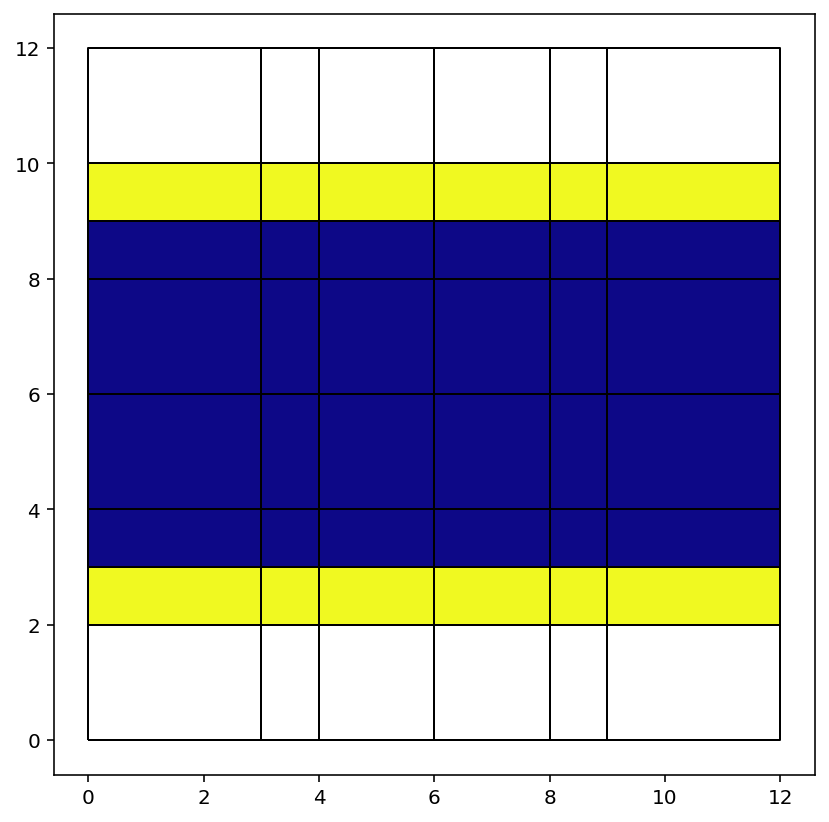

In [30]:
base = small_xwalk.plot(figsize=(7,7), cmap="plasma_r", column="wt", ec="k")
year1_small.plot(ax=base, fc="None", ec="k");

In [31]:
small_xwalk.drop("geometry", inplace=True, axis=1)

In [32]:
pop_mapper = dict(year1_small[["ID", "pop_y1"]].values)
small_xwalk["pop_y1"] = small_xwalk["ID_1"].map(pop_mapper)
small_xwalk.head(10)

,ID_1,ID_2,wt,_id_1,_id_2,pop_y1
0,y1_M000.s000,y2_L000.s000,0.333333,y1_M000,y2_L000,1
1,y1_M000.s100,y2_L000.s000,1.000000,y1_M000,y2_L000,2
2,y1_M000.s200,y2_L000.s000,0.333333,y1_M000,y2_L000,3
3,y1_M000.s300,y2_L000.s000,1.000000,y1_M000,y2_L000,4
4,y1_M010.s000,y2_L000.s000,1.000000,y1_M010,y2_L000,5
5,y1_M010.s200,y2_L000.s000,1.000000,y1_M010,y2_L000,7
6,y1_M030.s000,y2_L000.s000,0.333333,y1_M030,y2_L000,13
7,y1_M030.s100,y2_L000.s000,1.000000,y1_M030,y2_L000,14
8,y1_M040.s000,y2_L000.s000,1.000000,y1_M040,y2_L000,17
9,y1_M010.s100,y2_L000.s100,1.000000,y1_M010,y2_L000,6


In [33]:
atom_df = nhgisxwalk.calculate_atoms(
    small_xwalk,
    weight="wt",
    input_var="pop_y1",
    weight_var="pop_y1y2",
    source_id="_id_1",
    groupby_cols=["_id_1", "_id_2"]
)
atom_df

,_id_1,_id_2,pop_y1y2
0,y1_M000,y2_L000,1.000000
1,y1_M010,y2_L000,1.000000
2,y1_M020,y2_L000,1.000000
3,y1_M030,y2_L000,0.466102
4,y1_M030,y2_L010,0.533898
5,y1_M040,y2_L000,0.472973
6,y1_M040,y2_L010,0.527027
7,y1_M050,y2_L000,0.477528
8,y1_M050,y2_L010,0.522472
9,y1_M060,y2_L010,1.000000


In [34]:
atom_df["pop_y1y2"].sum()

9.0

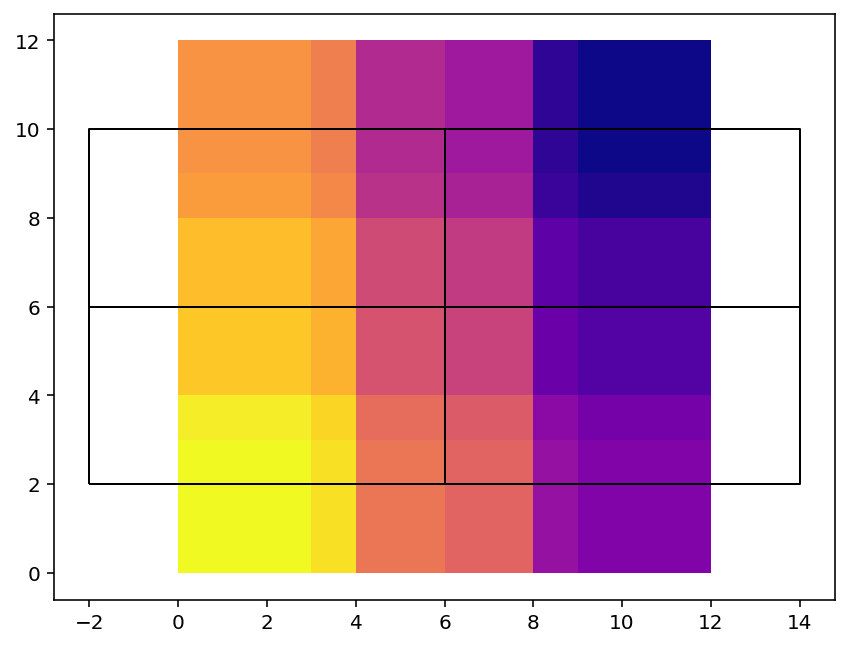

In [35]:
base = year1_small.plot(figsize=(7,7), cmap="plasma_r", column="pop_y1", zorder=0)
year2_small.plot(ax=base, fc="None", ec="k");

-------------------